# 08. Replicando Artigos com PyTorch

O objetivo de replicar artigos de pesquisa é torná-lo em código usável.

Nesse notebook, estaremos replicando a arquitetura do Vision Transformer (ViT). (https://arxiv.org/abs/2010.11929).

Materiais: https://www.learnpytorch.io/08_pytorch_paper_replicating/



## 0. Configurando

Vamos importar código que já escrevemos e bibliotecas necessárias.

In [ ]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.1.0+cu121
torchvision version: 0.16.0+cu121


In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Conseguindo os dados

O objetivo do que estamos fazendo é replicar a arquitetura do ViT para o problema do FoodVision Mini.

Precisamos dos nossos dados: As imagens de pizza, bife e sushi.

In [ ]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Criando Datasets e DataLoaders

In [ ]:
from going_modular.going_modular import data_setup
from torchvision import transforms

IMG_SIZE = 224 # De acordo com a Tabela 3 do Artigo do ViT

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print(f"Manual transforms: {manual_transforms}")

Manual transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [ ]:
# Usaremos um batch_size de 32 apesar de o paper usar 4096.
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
                              train_dir=train_dir,
                              test_dir=test_dir,
                              transform=manual_transforms,
                              batch_size=BATCH_SIZE
                              )


len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualizando uma única imagem

Como sempre, visualize, visualize, visualize

In [ ]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

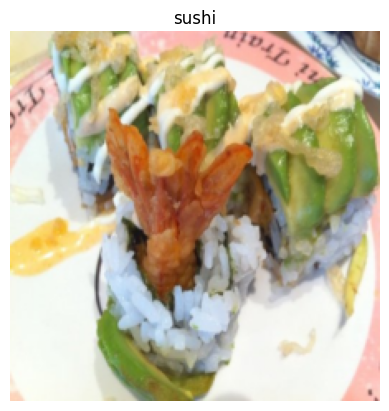

In [ ]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

## 3. Replicando ViT: Overview

Olhar um paper de pesquisa de machine learning pode ser intimidador.

Então, para aumentar a compreensão, podemos quebrá-lo em pedaços menores.

* **Inputs** - O que entra no modelo? (no nosso caso, tensores de imagens)
* **Outputs** - O que sai do modelo/camada/bloco? (no nosso caso, queremos labels de classificação)
* **Camadas** - Recebe uma entrada, a manipula com uma função (pode ser um self-attention)
* **Blocos** - Uma coleção de camadas
* **Modelo** - Uma coleção de blocos



## 3.1 ViT overview: peças do quebra-cabeça

* Figura 1: Overview da arquitetura
* Quatro equações: Define equações para as camadas/blocos
* Tabela 1/3: Diferentes hiperparâmetros para a arquitetura/treinamento
* Texto (especialmente a seção 3.1)

### Figura 1

![teste](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png)

* Embedding = Representação aprendível (começamos com números aleatórios e os melhoramos ao longo do tempo)



#### Quatro equações

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png)

----

**Equação 1**

```python
x_input = [class_token, image_patch_1, image_patch_2, ..., image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ..., image_patch_N_pos]
```

----
**Equações 2 e 3**
```python
# equação 2
# MSA = Multi-headed self attention
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# equação 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

----
Em tempo de treinamento: um MLP com uma camada oculta
Em tempo de fine-tunning: Uma camada linear apenas

```python
# Equação 4
y = Linear_layer(LN_layer(x_output_MLP_block))
```



#### Tabela 1/3

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png)

* ViT-Base, ViT-Large e ViT-Huge são diferentes tamanhos da mesma arquitetura
* ViT-B/16 = ViT-Base com o patch size igual a 16x16
* Layers = A quantidade de camadas Transformer-Encoder
* Hidden size $D$ = O tamanho do embedding ao longo da arquitetura
* MLP size = A quantidade de unidades ocultas no MLP
* Heads = A quantidade de multi-head self-attention


## 4. Equação 1: Dividir os dados em patches e criando embedings

Layers = entrada -> função -> saída

Qual o shape da entrada?
R: Uma imagem $H \times{W} \times{C}$ =  (224, 224, 3)

Qual o shape da saída?
R: $N \times{P^2} \cdot C$

* $H$ = Height
* $W$ = width
* $C$ = canais de cores
* $P$ = patch size
* $N$ = número de patches = $(H \times W) / P^2$
* $D$ = dimensões de embedding

In [ ]:
# Criando valores de exemplo
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculando a quantidade de patches
number_of_patches = int((height * width) / patch_size **2)
number_of_patches

196

In [ ]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (Imagem 2D): {embedding_layer_input_shape}")
print(f"Output shape (sequência 1D de patches): {embedding_layer_output_shape} -> (num_of_patches, embeddings)")

Input shape (Imagem 2D): (224, 224, 3)
Output shape (sequência 1D de patches): (196, 768) -> (num_of_patches, embeddings)


### 4.2 Tornando uma imagem em patches

Vamos visualizar.

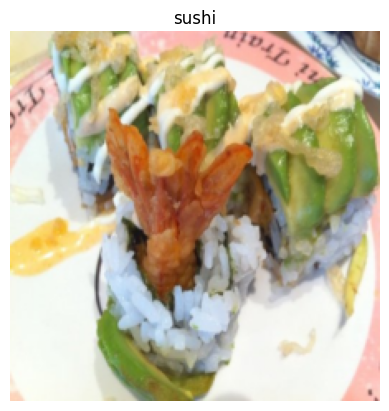

In [ ]:
# Uma única imagem
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [ ]:
image.shape

torch.Size([3, 224, 224])

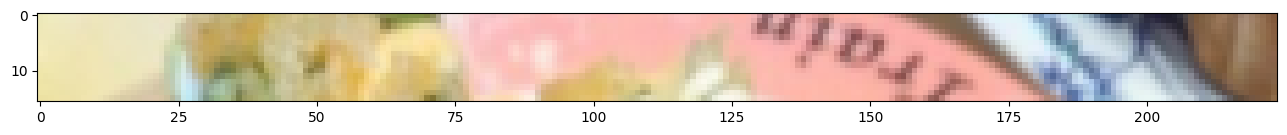

In [ ]:
# Conseguindo a linha do topo da imagem
image_permuted = image.permute(1, 2, 0)

# Indexando para plotar a linha do topo
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])
# plt.axis(False);

Número de patches por linha: 14.0
Patch size: 16 pixels x 16


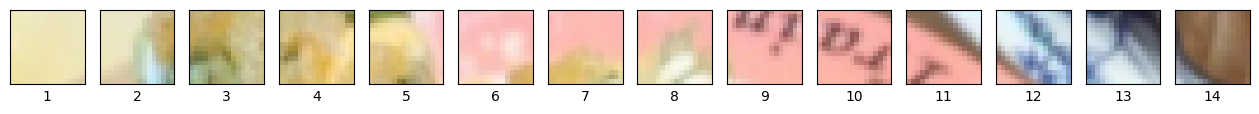

In [ ]:
# Configurando código para plotar a linha do topo como patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "O tamanho da imagem deve ser divisível pelo patch"
print(f"Número de patches por linha: {num_patches}")
print(f"Patch size: {patch_size} pixels x {patch_size}")

# Criando uma série de subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size,
                        sharey=True,
                        sharex=True,
                        figsize=(patch_size, patch_size)
                        )

# Iterando pela quantidade de patches na linha do topo
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Número de patches por linha e coluna: 14.0
Número total de patches: 196.0
Patch size: 16 pixels x 16


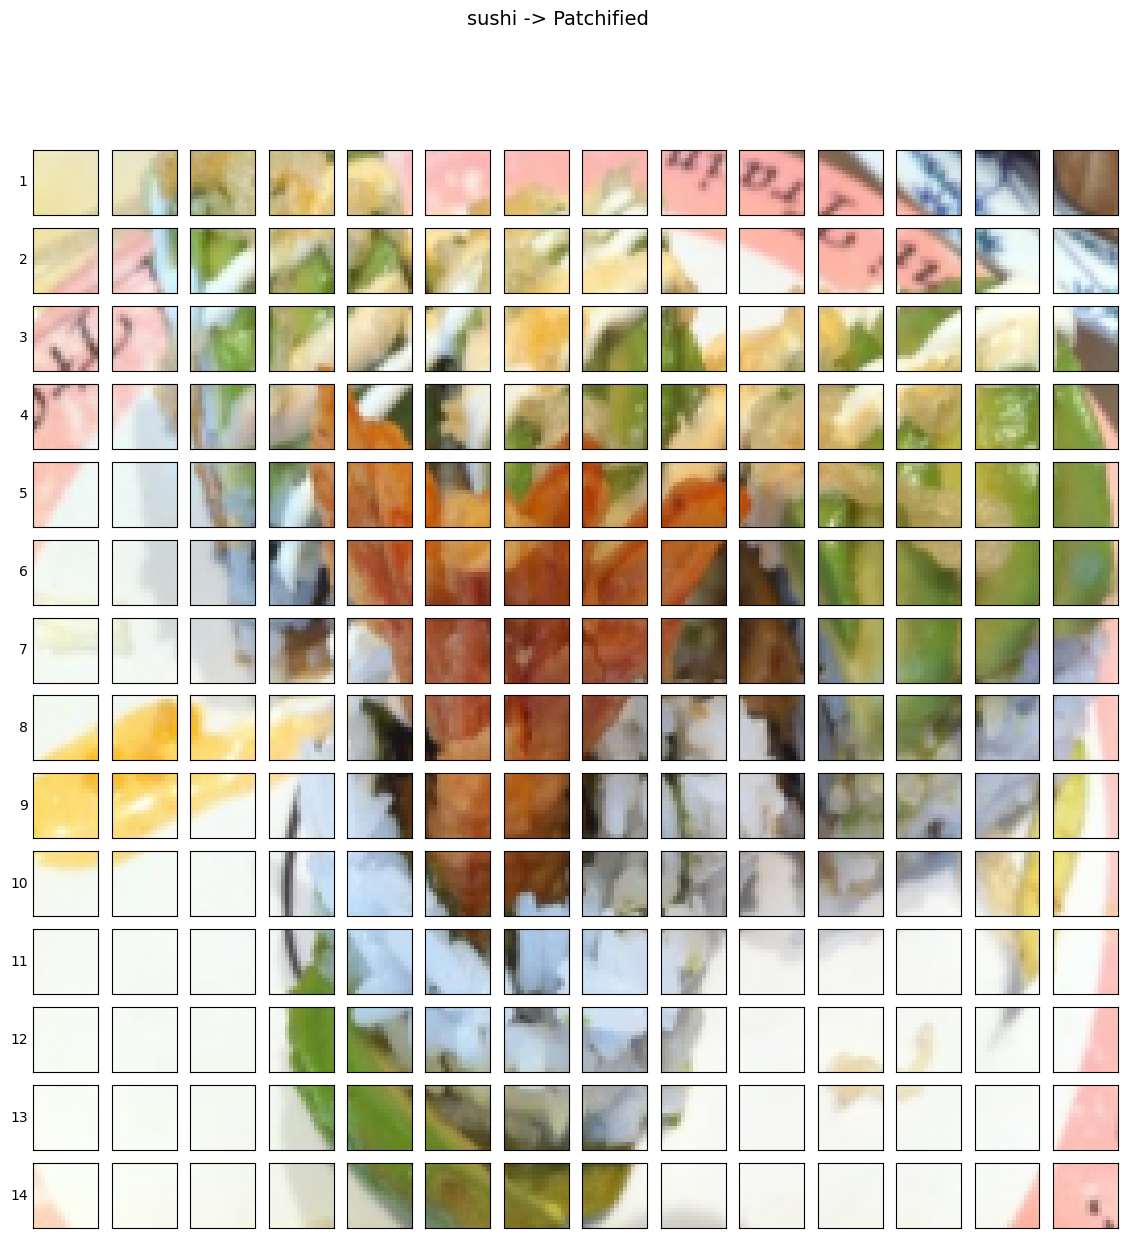

In [ ]:
# Configurando códigp para plotar uma imagem inteira como patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "O tamanho da imagem deve ser divisível pelo patch"
print(f"Número de patches por linha e coluna: {num_patches}")
print(f"Número total de patches: {num_patches*num_patches}")
print(f"Patch size: {patch_size} pixels x {patch_size}")

# Criando uma série de subplots
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

for i, patch_height in enumerate(range(0, img_size, patch_size)):
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    axs[i, j].imshow(image_permuted[patch_height:patch_size+patch_height,
                                    patch_width:patch_width+patch_size,
                                    :])
    axs[i, j].set_ylabel(i+1,
                         rotation="horizontal",
                         horizontalalignment="right",
                         verticalalignment="center")
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
plt.show()

### 4.3 Criando patches de imagens e as tornando em patch embeddings

Talvez podemos criar os patches de imagens e os embeddings em um único passo usando `torch.nn.Conv2d()` e definindo o kernel_size e o stride iguais ao `patch_size`.

In [ ]:
# Criando camada Conv2d para tornar os patches da imagem em feature maps (embeddings)
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels= 3, #Para imagens coloridas
                   out_channels=768, # D size da tabela 1
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

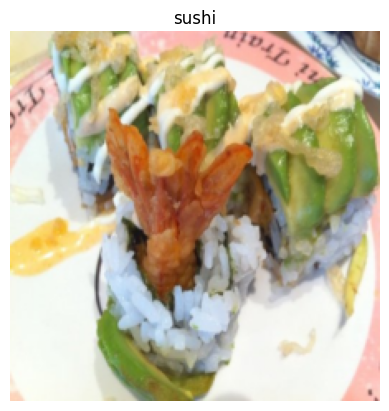

In [ ]:
# Visualizando uma imagem
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [ ]:
# Realizando uma passada da imagem pela camada convolucional
image_out_of_conv = conv2d(image.unsqueeze(0)) # add dimensão de batch
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


14*14 é igual a 196 que é a quantidade de patches

```python
torch.Size([1, 768, 14, 14]) # [batch_size, embed_dim, feat_map_height, feature_map_width]
```

In [ ]:
image_out_of_conv.requires_grad

True

Mostrando feature maps convolucionais aleatórios dos indexes: [378, 414, 748, 14, 39]


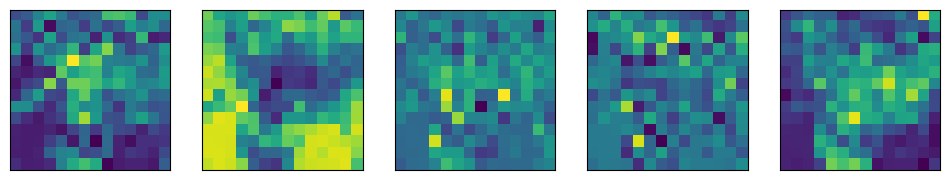

In [ ]:
# plot feature maps convolucionais aleatórios
import random
random_indexes = random.sample(range(0, 758), k=5)
print(f"Mostrando feature maps convolucionais aleatórios dos indexes: {random_indexes}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

for i, idx in enumerate(random_indexes):
  image_conv_feat_map = image_out_of_conv[:, idx, :, :]
  axs[i].imshow(image_conv_feat_map.squeeze().detach().numpy()) # remove dim de batch e remove o acompanhamento de grad
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
# Conseguindo um feat map em forma de tensor
single_feat_map = image_out_of_conv[:, 0, :, :]
single_feat_map, single_feat_map.requires_grad

(tensor([[[-0.2718, -0.2080, -0.2534, -0.3054, -0.2245, -0.2246, -0.2452,
           -0.2756, -0.1576, -0.1764, -0.2070, -0.1971, -0.0442, -0.1824],
          [-0.2332, -0.1699, -0.0814, -0.1945, -0.2302, -0.2455, -0.3165,
           -0.1744, -0.2855, -0.2088, -0.2246, -0.0973, -0.2383, -0.1324],
          [-0.2156, -0.1232, -0.2643, -0.1525, -0.3450, -0.3841, -0.2455,
           -0.3518, -0.3521, -0.2549, -0.4197, -0.1683, -0.2144, -0.3031],
          [-0.1635, -0.2177, -0.1531, -0.3466, -0.2215, -0.1673, -0.3366,
           -0.1875, -0.1256, -0.2584, -0.2174, -0.2719, -0.1878, -0.2456],
          [-0.2361, -0.2212, -0.1522, -0.1446, -0.2477, -0.1455, -0.1585,
           -0.1149, -0.3028, -0.1581, -0.2765, -0.2335, -0.1440, -0.1666],
          [-0.2611, -0.2266, -0.1067, -0.0920, -0.1346, -0.1901, -0.1578,
           -0.1997, -0.0448, -0.1251, -0.2667, -0.2171, -0.1949, -0.2386],
          [-0.2676, -0.2489, -0.2349, -0.1777, -0.1970, -0.1533, -0.0932,
           -0.1713, -0.1343, -0.

### 4.4 Flattenning (achatando) o embedding do patch com `torch.nn.Flatten()`

Nesse momento, temos uma série de feature maps convolucionais que queremos realizar o flatten para satisfazer os critérios do ViT Transformer Encoder.

In [ ]:
print(f"{image_out_of_conv.shape} -> original")
print(f"Queremos (batch_size, n_patches, embedding_dim)")

torch.Size([1, 768, 14, 14]) -> original
Queremos (batch_size, n_patches, embedding_dim)


In [ ]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2, end_dim=3)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


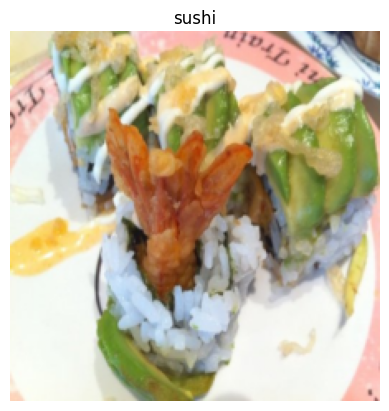

In [ ]:
# Juntando tudo
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

image_out_of_conv= conv2d(image.unsqueeze(0))
print(f"Image feature map shape: {image_out_of_conv.shape}")

image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [ ]:
# Reordenando a saída da camada flatten
image_out_of_conv_flattened_perm = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"{image_out_of_conv_flattened_perm.shape} -> (batch, n_patches, embed_dims)")

torch.Size([1, 196, 768]) -> (batch, n_patches, embed_dims)


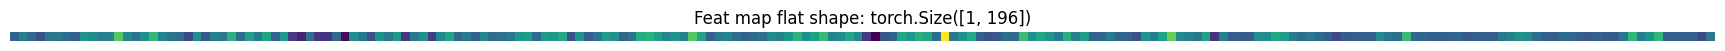

In [ ]:
# Conseguindo um feature map flattened
single_flattened_feat_map = image_out_of_conv_flattened_perm[:, :, 0]

# Plot do feat map flat
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feat_map.detach().numpy())
plt.title(f"Feat map flat shape: {single_flattened_feat_map.shape}")
plt.axis(False);


### 4.5 Tornando a camada de embedding ViT em um módulo PyTorch

Queremos que esse módulo faça algumas coisas:
1. Crie uma classe chamada `PatchEmbedding`
2. Inicializar com hiperparâmetros apropriados tais como canais, embed dims e patch size
3. Criar uma camada para tornar a imagem em embedd patches usando `nn.Conv2d()`
4. Criar uma camada para realizar o flatten dos feat maps que sairem da camada em 3.
5. Definir um `forward()` que define uma computação
6. Garantir que o shape de output reflita o shape de saída necessário

In [ ]:
# 1.
class PatchEmbedding(nn.Module):
  # 2.
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768):
    super().__init__()
    self.patch_size = patch_size
    # 3.
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)
    # 4.
    self.flatten = nn.Flatten(start_dim=2, end_dim=3)

  # 5.
  def forward(self, x):
    img_res = x.shape[-1]
    assert img_res % self.patch_size == 0, f"Img size must be divisible by {self.patch_size}"

    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    # 6.
    return x_flattened.permute(0, 2, 1)

In [ ]:
set_seeds()
patchify = PatchEmbedding(patch_size=16,
               in_channels=3,
               embedding_dim=768)
print(f"Input image size: {image.unsqueeze(0).shape}")

patched_embed_img = patchify(image.unsqueeze(0))
print(f"Output patch embedd shape: {patched_embed_img.shape}")


Input image size: torch.Size([1, 3, 224, 224])
Output patch embedd shape: torch.Size([1, 196, 768])


In [ ]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250)

# patchify(rand_image_tensor_bad)

### 4.6 Criando o embedding de token de classe

Queremos incluir um token de classe no início embedding do patch.



In [ ]:
# Conseguindo o tamanho do batch e do embedding
batch_size = patched_embed_img.shape[0]
embedding_dimension = patched_embed_img.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [ ]:
# Cria um embedding de token de classe como um parãmetro aprendivel
class_token = nn.Parameter(
    torch.ones(batch_size, 1, embedding_dimension), # Devemos inicializar como aleatório na verdade
    requires_grad=True
    )
class_token.shape

torch.Size([1, 1, 768])

In [ ]:
patched_embed_img.shape

torch.Size([1, 196, 768])

In [ ]:
# Adicionando o embedding de token de classe no início do embedding do patch
patch_embedded_image_with_class_embedding = torch.cat((class_token, patched_embed_img),
                                                      dim=1) # dimensão do número de patches
print(patch_embedded_image_with_class_embedding)
print(f"Sequência de patch embeddings com os tokens de class adicionados: {patch_embedded_image_with_class_embedding.shape} -> (batch_size, n_patches + class_token, embed_dim)")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.9168,  0.2429, -0.2294,  ...,  0.6771, -0.4509,  0.3483],
         [-0.7427,  0.1953, -0.3559,  ...,  0.5824, -0.3451,  0.3274],
         ...,
         [-1.0077,  0.2796, -0.2795,  ...,  0.7628, -0.4584,  0.3580],
         [-0.9839,  0.1649, -0.1600,  ...,  0.7498, -0.5472,  0.3500],
         [-0.9262,  0.1364, -0.1151,  ...,  0.5843, -0.4750,  0.3103]]],
       grad_fn=<CatBackward0>)
Sequência de patch embeddings com os tokens de class adicionados: torch.Size([1, 197, 768]) -> (batch_size, n_patches + class_token, embed_dim)


### 4.7 Criando o embedding posicional

Queremos criar uma série de embeddings posicionais aprendíveis 1D e os adicionar à sequência de embeddings de patch

In [ ]:
# Vendo a sequência de embeddings de patch com o embedding de classe
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.9168,  0.2429, -0.2294,  ...,  0.6771, -0.4509,  0.3483],
          [-0.7427,  0.1953, -0.3559,  ...,  0.5824, -0.3451,  0.3274],
          ...,
          [-1.0077,  0.2796, -0.2795,  ...,  0.7628, -0.4584,  0.3580],
          [-0.9839,  0.1649, -0.1600,  ...,  0.7498, -0.5472,  0.3500],
          [-0.9262,  0.1364, -0.1151,  ...,  0.5843, -0.4750,  0.3103]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

O embedding posicional deve ser adicionado em todas as dimensões

In [ ]:
# Calculando o número de patches
number_of_patches = int((height * width / patch_size**2))

# Conseguindo a dimensão de embdding
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Criando o embedding posicional 1D
position_embedding = nn.Parameter(
    torch.ones(1, number_of_patches+1, # Como estamos usando apenas uma imagem, temos o 1. Se fosse um batch, colocaríamos ele no lugar
               embedding_dimension),
    requires_grad=True
)

position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [ ]:
# Adicionando o embedding posicional aos embeddings de patch e classe
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding, patch_and_position_embedding.shape

(tensor([[[ 2.0000,  2.0000,  2.0000,  ...,  2.0000,  2.0000,  2.0000],
          [ 0.0832,  1.2429,  0.7706,  ...,  1.6771,  0.5491,  1.3483],
          [ 0.2573,  1.1953,  0.6441,  ...,  1.5824,  0.6549,  1.3274],
          ...,
          [-0.0077,  1.2796,  0.7205,  ...,  1.7628,  0.5416,  1.3580],
          [ 0.0161,  1.1649,  0.8400,  ...,  1.7498,  0.4528,  1.3500],
          [ 0.0738,  1.1364,  0.8849,  ...,  1.5843,  0.5250,  1.3103]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

### 4.8 Juntando tudo: de imagem para embedding

Escrevemos o código para transformar uma imagem em uma sequência de embeddings de patch flattened.

Vamos colocar tudo em uma célula só



In [ ]:
set_seeds()

patch_size = 16

print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# Add batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(
    batch_size, 1, embedding_dimension), # Na vdd, deveria ser random
                           requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding com class token shape: {patch_embedding_class_token.shape}")

number_of_patches = int((height*width) // patch_size**2)
position_embedding = nn.Parameter(torch.ones(
    batch_size, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding com class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## Equação 2: Multihead Self-Attention (MSA block)

* MSA: Qual parte de uma sequencia deveria prestar mais atenção à ela mesma?
  * No nosso caso, temos vários embeddings de patches de imagens, qual patch se relaciona mais fortemente com qual outro patch?
  * Queremos que a nossa rede neural (ViT) aprenda esse relacionamente/representação.
* Podemos usar https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html
* LayerNorm: Layer normalization (LayerNorm) is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy https://arxiv.org/abs/1911.07013
  * Normalização: Faz com que tudo tenha a mesma média e desvio padrão
  * Em PyTorch: https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html, normaliza valores sobre $D$ dimensões, no caso, a dimensão do embedding.
    * Quando normalizamos ao longo da dimensão de embedding, é como fazer todos os degraus de uma escada do mesmo tamanho.



In [ ]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """
  Cria um bloco multi-head self-attention (MSA).
  """
  def __init__(self,
               embedding_dim:int=768, #D
               num_heads:int=12, #Heads
               attn_dropout:int=0):
    super().__init__()
    # Cria a camada de normalização (LN)
    self.layer_norm = nn.LayerNorm(
        normalized_shape=embedding_dim)

    # Cria a camada multihead attention (MSA)
    self.multihead_attn = nn.MultiheadAttention(
        embed_dim=embedding_dim,
        num_heads=num_heads,
        dropout=attn_dropout,
        batch_first=True) # Muda a ordem esperada da tupla de entrada para (batch, seq, feat)

  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query=x,
                                         key=x,
                                         value=x,
                                         need_weights=False)
    return attn_output


In [ ]:
# Criando uma instância do bloco MSA
multihead_self_attention_block = MultiHeadSelfAttentionBlock(
    embedding_dim=768, num_heads=12, attn_dropout=0
)

# Passa a sequência de embeddings de patch e posição da imagem
patched_image_through_msa_block = multihead_self_attention_block(
    patch_and_position_embedding
)
print(f"Input shape do bloco MSA: {patch_and_position_embedding.shape}")
print(f"Output shape do bloco MSA: {patched_image_through_msa_block.shape}")

Input shape do bloco MSA: torch.Size([1, 197, 768])
Output shape do bloco MSA: torch.Size([1, 197, 768])


## 6. Equação 3: Bloco Multilayer Perceptron

* **MLP** = O MLP contém duas camadas com função de não linearidade GELU.
  * MLP = Um termo geral para um bloco com uma ou várias camadas
  * Camadas podem significar: completamente conectadas, densa, linear, feed-forward são nomes para a mesma coisa. No PyTorch, eles são chamados `torch.nn.Linear`.
  * GELU em PyTorch: https://pytorch.org/docs/stable/generated/torch.nn.GELU.html
  

* **Dropout** = Aplicado depois de toda camada densa no artigo menos após o MSA.

Pseudocódigo:

```python
# MLP
x = linear -> non-linear -> dropout -> linear -> dropout
```

In [ ]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072, #De acordo com a tabela do artigo
               dropout:int=0.1):
    super().__init__()

    # Cria a camada de normalização (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Cria o MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x
    # return self.mlp(self.layer_norm(x))

In [ ]:
# Cria uma instância do MLPBlock
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

# Realiza uma passada da saída do MSABlock pelo MLPBlock
patched_image_through_mlp_block = mlp_block(
    patched_image_through_msa_block
    )

print(f"Input shape bloco MLP: {patched_image_through_msa_block.shape}")
print(f"Output shape bloco MLP: {patched_image_through_mlp_block.shape}")

Input shape bloco MLP: torch.Size([1, 197, 768])
Output shape bloco MLP: torch.Size([1, 197, 768])


### 7. Criando o Transformer Encoder

Ele é formado por uma alternância entre blocos MSA e MLP.

E existem conexões residuais entre cada bloco.

* Encoder = Transforma uma sequência em representações aprendíveis.
* Decoder = Vai de uma representação para uma sequência.
* Conexões residuais = Adiciona a própria entrada na saída de uma camada. Isso permite a criação de redes mais profundas (previne os pesos de ficarem muito pequenos).

Em pseudocódigo:
```python
# Transformer Encoder
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...
```

### 7.1 Criando um bloco Transformer Encoder do zero

In [ ]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int = 768,
               num_heads:int=12,
               mlp_size:int=3072,
               mlp_dropout:int=0.1,
               attn_dropout:int=0
               ):
    super().__init__()

    # Cria o bloco MSA
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout
                                                 )

    # Cria o bloco MLP
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)


  def forward(self, x):
    x = self.msa_block(x) + x # conexão residual/skip connection
    x = self.mlp_block(x) + x # residual/skip connection
    return x


In [ ]:
# Criando uma instância de TransformerEncoderBlock()
transformer_encoder_block = TransformerEncoderBlock()

# Conseguindo um summary
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, n_patches, embd_dims)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Criando uma camada Transformer Encoder com camadas built-in do PyTorch

Criamos um Transformer Encoder na mão, entretanto, o PyTorch já possui algumas camadas Transformer implementadas.

Podemos criar uma camada Transformer Encoder usando camadas implementadas pelo PyTorch.


In [ ]:
# Criando a classe anterior mas com built-in
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(
    d_model=768,
    nhead=12,
    dim_feedforward=3072,
    dropout=0.1,
    activation="gelu",
    batch_first=True,
    norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, n_patches, embd_dims)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

Por quê gastar esse tempo todo implementando o transformer encoder quando já existia a implementação pronta do PyTorch?

Para praticar!

Agora sabemos como as coisas são implementadas por trás e podemos alterá-las se nececssário.

Benefícios de usar uma camada já pronta:

* Menos chance de existirem erros
* Benefício pontencial de melhoras de performance

## 8. Juntando tudo para criar o ViT

In [ ]:
# Criando uma classe ViT
class ViT(nn.Module):
  def __init__(self,
               img_size:int=224,
               in_channels:int=3,
               patch_size:int=16,
               num_transformer_layers:int=12,
               embedding_dim:int=768,
               mlp_size:int=3072,
               num_heads:int=12,
               attn_dropout:int=0,
               mlp_dropout:int=0.1,
               embedding_dropout:int=0.1,
               num_classes:int=1000):

    super().__init__()

    # Fazendo uma asserção de que o tamanho da img é compatível com o patch

    assert img_size % patch_size == 0, f"Size da imagem deve ser divisível pelo patch!"

    # Calculando o número de patches
    self.num_patches = (img_size * img_size) // patch_size**2

    # Cria embeddings aprendíveis
    self.class_embedding = nn.Parameter(data=torch.randn(1 ,1, embedding_dimension),
                                        requires_grad = True)

    # Criando os embeddings posicionais
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1,
                                                            embedding_dim))

    # Criando o valor de dropout de embedding
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # Criando a camada de patch embedding
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # Criando o bloco de transformer encoder
    self.transformer_encoder = nn.Sequential(
        *[
            TransformerEncoderBlock(embedding_dim=embedding_dim,
                                  num_heads=num_heads,
                                  mlp_size=mlp_size,
                                  mlp_dropout=mlp_dropout)
        for _ in range(num_transformer_layers)])

    # Cria o head de classificação
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    # conseguindo o batch size
    batch_size = x.shape[0]

    # Criando o embedding de token de classe
    # e o copiando para todas as imagens no batch
    class_token = self.class_embedding.expand(batch_size, -1, -1) #-1 significa inferir as dimensões

    # Criando o embedding de patch
    x = self.patch_embedding(x)

    # Concatenando o embedding de token de classe com o embedding de patch
    x = torch.cat((class_token, x), dim=1)

    # Adicionando o embedding posicional
    x = self.position_embedding + x

    # Aplicando dropout para os embeddings de patch
    x = self.embedding_dropout(x)

    # Passando os embeddings para o transformer encoder
    x = self.transformer_encoder(x)

    # Passa o logit no índice 0 pelo classificador
    x = self.classifier(x[:, 0])

    return x

In [ ]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiHeadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
  

In [ ]:
set_seeds()

# Cria um tensor de imagem aleatório
random_image_tensor = torch.randn(1, 3, 224, 224)

# Cria uma instâcnai da arquitetura ViT
vit = ViT(num_classes=len(class_names))

# Passa a imagem aleatório pela instância
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

### Conseguindo um sumário visual do nosso modelo ViT


In [ ]:
from torchinfo import summary

summary(model=ViT(num_classes=len(class_names)),
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

## 9. Configurando o códdigo de treino para o nosso ViT

Nós replicamos a arquitetura ViT, agora vamos ver como ele performa nos dados de Mini Food Vision.

### 9.1 Criando um otimizador

O paper diz que usa o otimizador Adam com $\beta_1 = 0.9$, $\beta_2 = 0.999$, e decaimento de peso de $0.1$. Decaimento de peso (weight decay) é uma forma de regularização que penaliza grandes pesos na rede. Ele consegue isso ao adicionar um termo à função de perda que é proporcional à soma dos pesos ao quadrado. Esse termo reduz a magnitude dos pesos e os previne de crescer muito.

Técnica de regularização = previne overfitting.

### 9.2 Criando uma função de perda

O paper não menciona qual função de perda eles usaram. Já que é um problema de classificação multiclasses,  usaremos o `torch.nn.CrossEntropyLoss`.

### 9.3 Treinando o nosso modelo ViT

In [ ]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=0.001,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

loss_fn = torch.nn.CrossEntropyLoss()

results = engine.train(
    model=vit,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    epochs=10,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6697 | train_acc: 0.3086 | test_loss: 1.2545 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.5149 | train_acc: 0.3203 | test_loss: 1.0593 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.3925 | train_acc: 0.4219 | test_loss: 1.3158 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2488 | train_acc: 0.4219 | test_loss: 2.3024 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.5335 | train_acc: 0.2852 | test_loss: 1.9660 | test_acc: 0.1979
Epoch: 6 | train_loss: 1.5853 | train_acc: 0.3164 | test_loss: 1.2593 | test_acc: 0.5417
Epoch: 7 | train_loss: 1.3238 | train_acc: 0.4375 | test_loss: 1.1766 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.2108 | train_acc: 0.2617 | test_loss: 1.9692 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.5777 | train_acc: 0.2891 | test_loss: 1.4056 | test_acc: 0.1979
Epoch: 10 | train_loss: 1.1396 | train_acc: 0.4219 | test_loss: 1.1256 | test_acc: 0.5417


### 9.4 O que está faltando no nosso setup de treinamento

Nós replicamos a arquitetura corretamente. Entretanto, quais são as diferenças entre o nosso treinamento em relação ao do paper para que o nosso atingisse performance tão baixa?

As principais diferenças são:

Previne underfitting:
* Menos dados: usamos 225 contra milhões no paper

Previne overfitting:
* Learning rate warmup: Começa com um learning rate pequeno e aumenta até um valor base
* Learning rate decay: À medida que o modelo chega perto de convergência, começamos a diminuir o learning rate
* Gradient clipping: Previne gradientes de ficarem muito grandes

### 9.5 Plotando curvas de loss para o nosso modelo

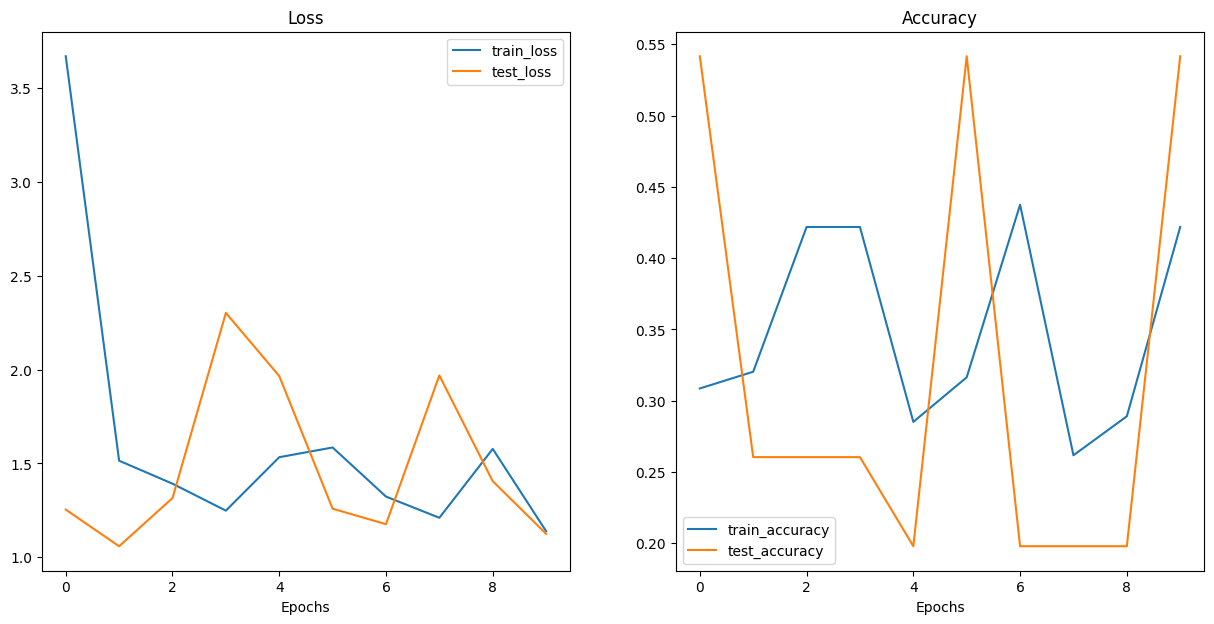

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

## 10. Usando um ViT pré-treinado de `torchvision.models`

Geralmente, se você puder um modelo pré-treinado em um dataset maior, esse é um bom começo.

Se encontrarmos um modelo pré-treinado, podemos tentar usá-lo com nossos poucos dados e conseguir bons resultados.

###10.1 Por quê usar um modelo pré-treinado?

* Dados limitados
* Recursos de treinamento limitados
* Conseguir resultados melhores mais rápido (às vezes)

In [ ]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu121
0.16.0+cu121


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 10.2 Preparando um ViT pré-treinado para usar no FoodVision Mini (transformando-o em um feature extractor)

In [ ]:
# Conseguindo pesos do modelo pré-treinado
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# Configurando uma instância do modelo com pesos pré-treinados
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)


# Congelando os parâmetros base
for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:06<00:00, 56.0MB/s]


In [ ]:
from torchinfo import summary

summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 1000]            768                  False
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 197

Vamos substituir a camada heads para as nossas necessidades

In [ ]:
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768,
                                 out_features=len(class_names)).to(device)

In [ ]:
summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

Agora temos um modelo configurado para o nosso problema de prever apenas 3 classes

### 10.3 Preparando dados para o modelo pré-treinado

Ao usar um model pré-treinado, queremos ter certeza de que os nossos dados estejam no mesmo formato em que o modelo foi treinado.

In [ ]:
# Conseguindo as transformação automáticas necessárias
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
# Configurando DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transforms,
    # Poderíamos usar um batch size maior em um modelo pré treinado
    # Pois teremos menos cálculos durante o fine-tunning
    batch_size=32
)

### 10.4 Treinando o modelo feature extractor ViT

In [ ]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

# Treinando o head de classificação
set_seeds()
pretrained_vit_results = engine.train(
    model=pretrained_vit,
    train_dataloader=train_dataloader_pretrained,
    test_dataloader=test_dataloader_pretrained,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


### 10.5 Plotando as curvas de loss do nosso modelo ViT extrator de features

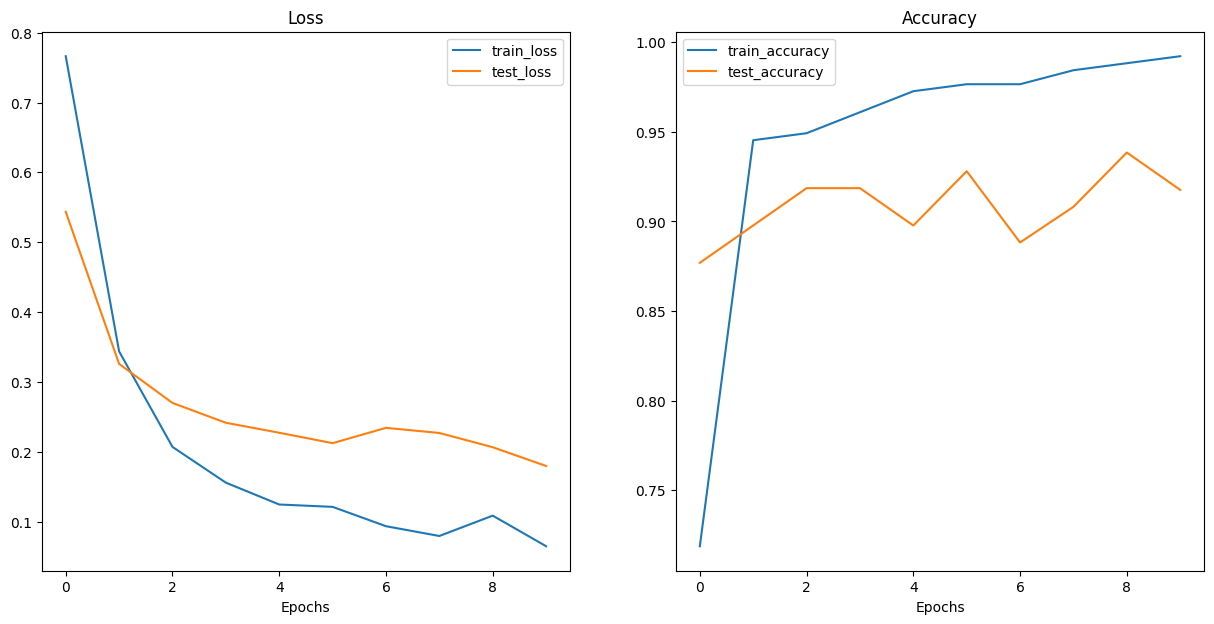

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

### 10.6 Salvando o nosso melhor modelo ViT

Agora nós temos um modelo que performa bem. Que tal o salvarmos em um arquivo e depois checarmos o seu tamanho? Queremos checar o tamanho do arquivo pois, se quiséssemos realizar o deploy do modelo em uma aplicação web/mobile, poderíamos ter limitações no tamanho do modelo. Por exemplo, um modelo menor poderia ser melhor devido a restrições de computação

In [ ]:
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                  target_dir="models",
                  model_name="08_pretrained_vit_feat_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feat_extractor_pizza_steak_sushi.pth


In [ ]:
from pathlib import Path

pretrained_vit_model_size = Path("models/08_pretrained_vit_feat_extractor_pizza_steak_sushi.pth").stat().st_size // (1024**2)
print(f"pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

pretrained ViT feature extractor model size: 327 MB


Talvez seja um modelo muito pesado.

## 11. Predizendo em uma imagem escolhida

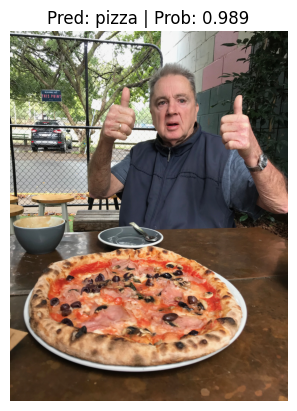

In [ ]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)